# SML Pratical

Music Genre Classification


In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load dataset

In [2]:
### data loading ###
X = pd.read_csv('data/X_train.csv', index_col = 0, header=[0, 1, 2]) # inputs 
y = pd.read_csv('data/y_train.csv', index_col = 0).squeeze('columns') # labels

# total number of rows and columns(attributes)
n, p = np.shape(X)


In [3]:
### map the character labels to numerical ### 

class_label_mapping = {}

def transform_labels_to_numbers(labels):
    """
    Take class labels, and transform them to 0, 1, ..., K (where K is total number of classes)

    :param labels: 1d pd Series, contains class labels
    
    :return transformed_labels: 1d numpy array of the same shape as labels, contains numerical values
    :return class_label_mapping: dictionary, records the correspondance between numbers and original classes
    """
    unique_labels = set(labels)
    
    for i, label in enumerate(unique_labels):
        class_label_mapping[label] = i

    transformed_labels = [class_label_mapping[label] for label in labels]
    
    return transformed_labels, class_label_mapping

y, label_mapping = transform_labels_to_numbers(y)
y = pd.Series(y)

In [4]:
### check class weights ###

# Calculate class weights
classes = np.unique(y)
class_counts = np.bincount(y)
class_weights = class_counts / n

# Print class weights
for genre, weight in zip(classes, class_weights):
    print(f'Genre {genre}: Weight {weight}')

Genre 0: Weight 0.12916666666666668
Genre 1: Weight 0.12233333333333334
Genre 2: Weight 0.12283333333333334
Genre 3: Weight 0.12183333333333334
Genre 4: Weight 0.12783333333333333
Genre 5: Weight 0.1265
Genre 6: Weight 0.12633333333333333
Genre 7: Weight 0.12316666666666666


In [5]:
print(f"features: {X.columns.get_level_values('feature').unique().tolist()}")
print(f"statistics: {X.columns.get_level_values('statistics').unique().tolist()}")

features: ['chroma_cens', 'chroma_cqt', 'chroma_stft', 'mfcc', 'rmse', 'spectral_bandwidth', 'spectral_centroid', 'spectral_contrast', 'spectral_rolloff', 'tonnetz', 'zcr']
statistics: ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']


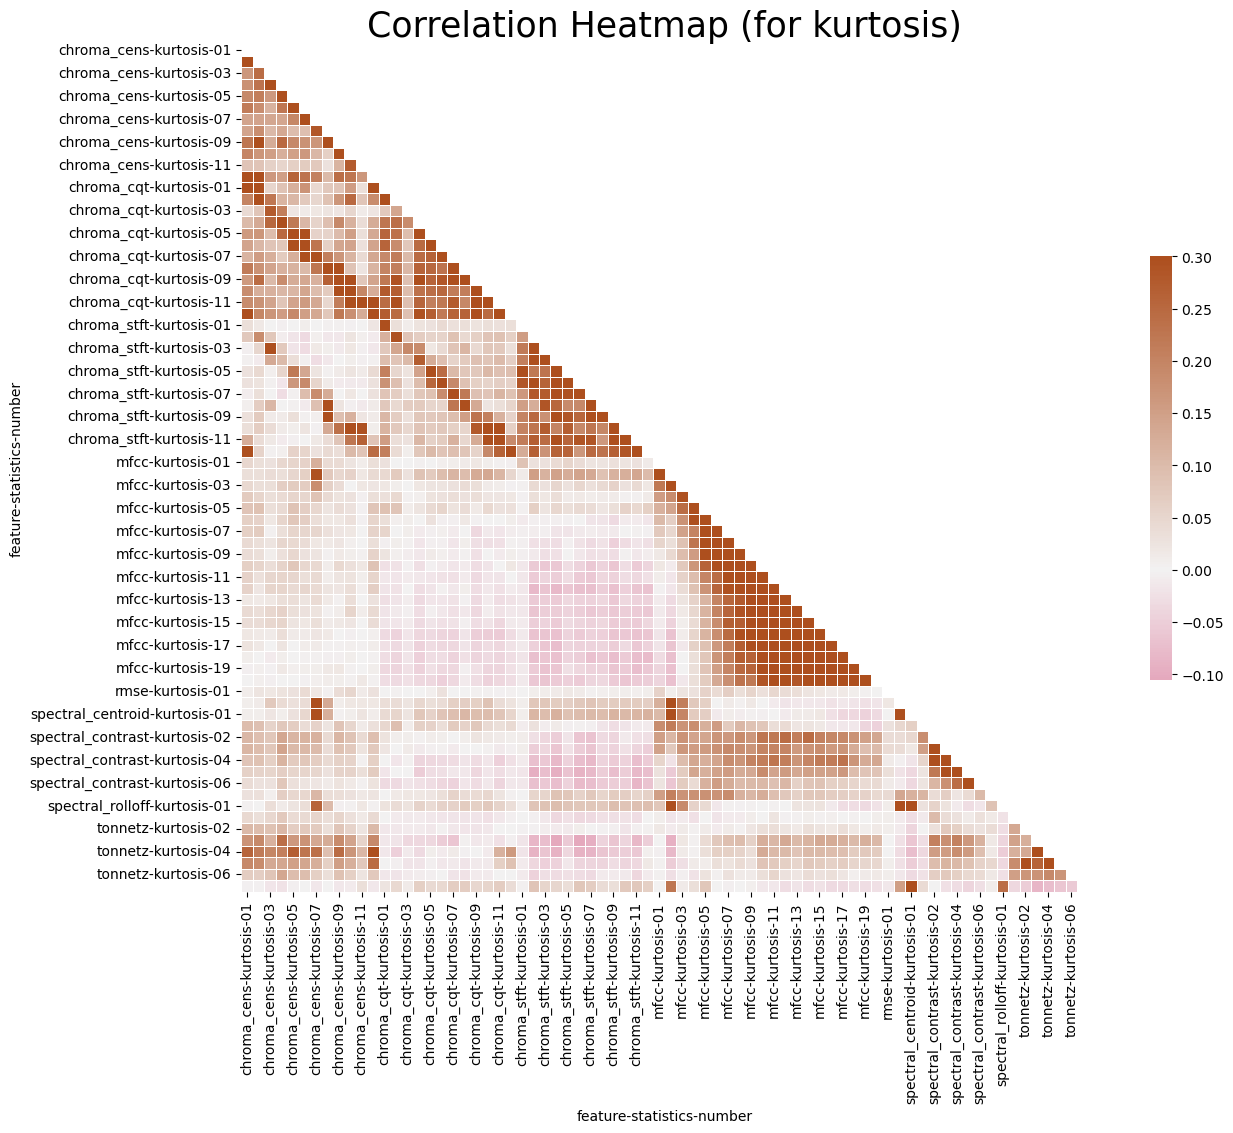

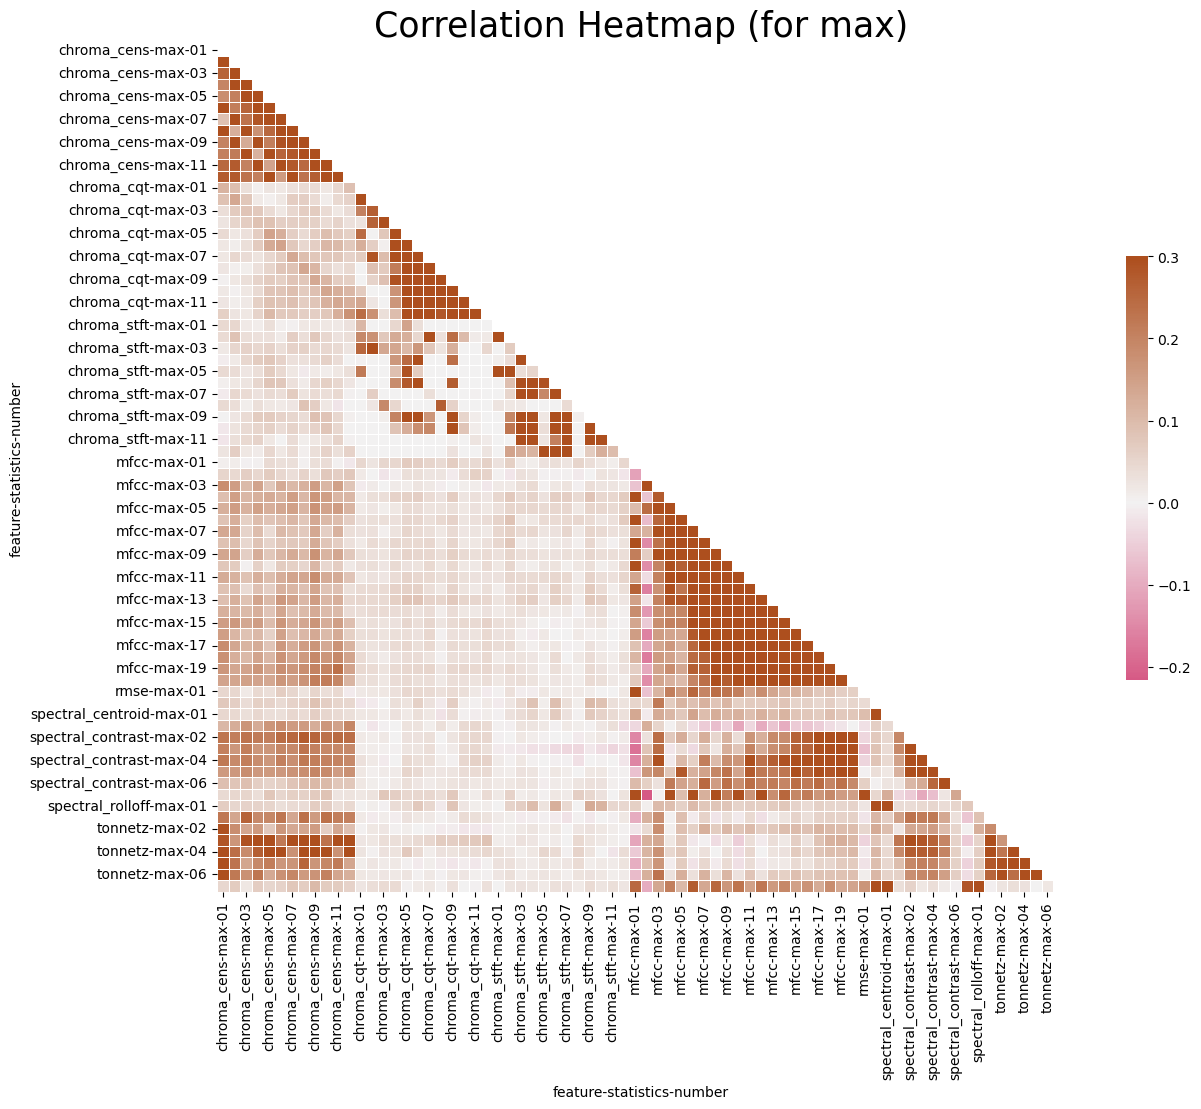

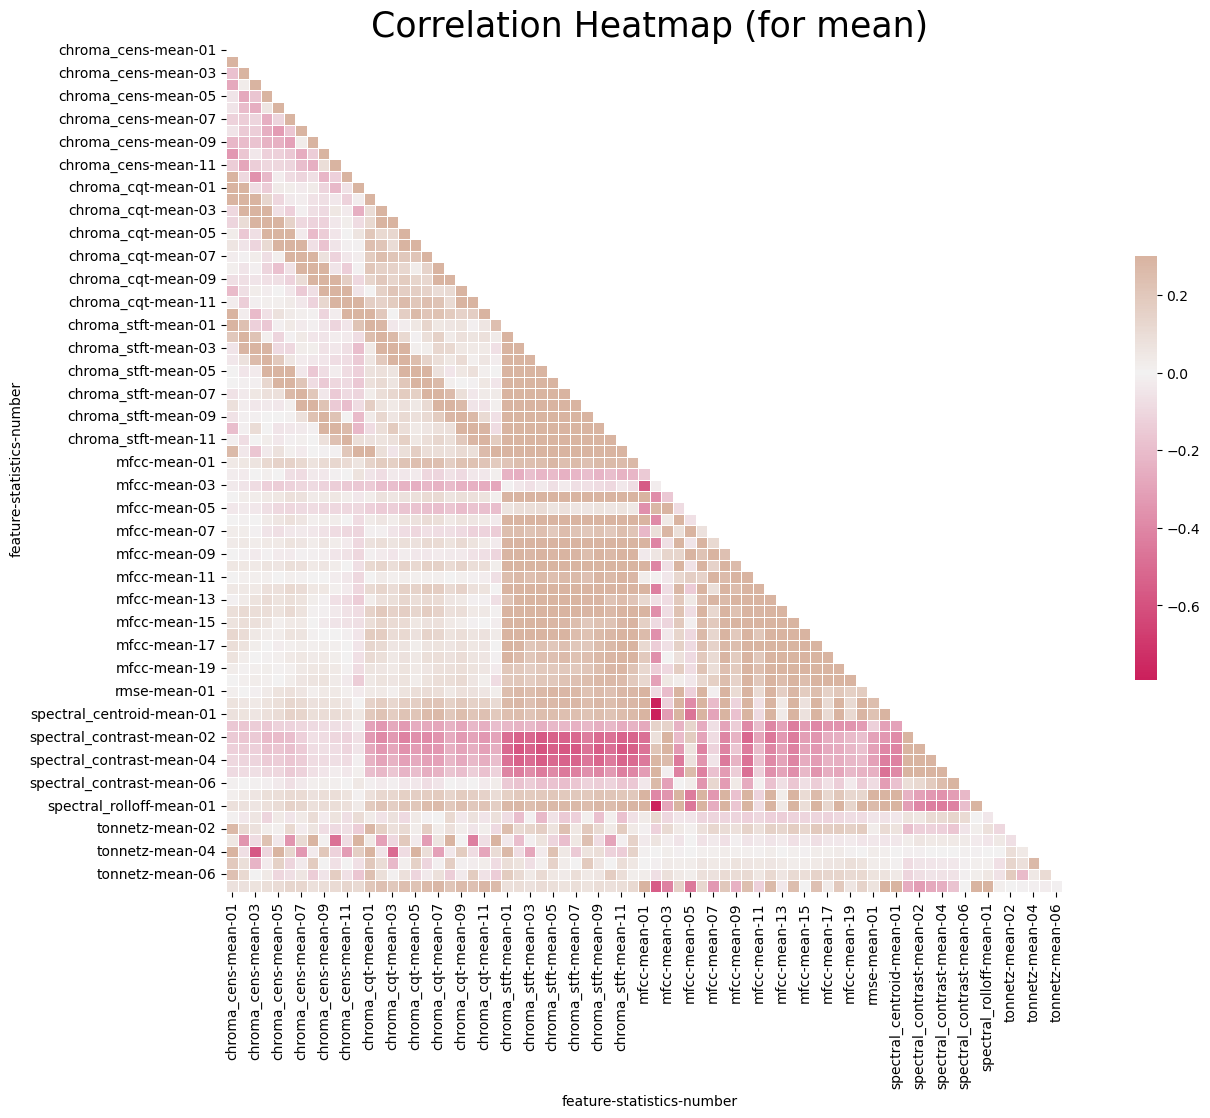

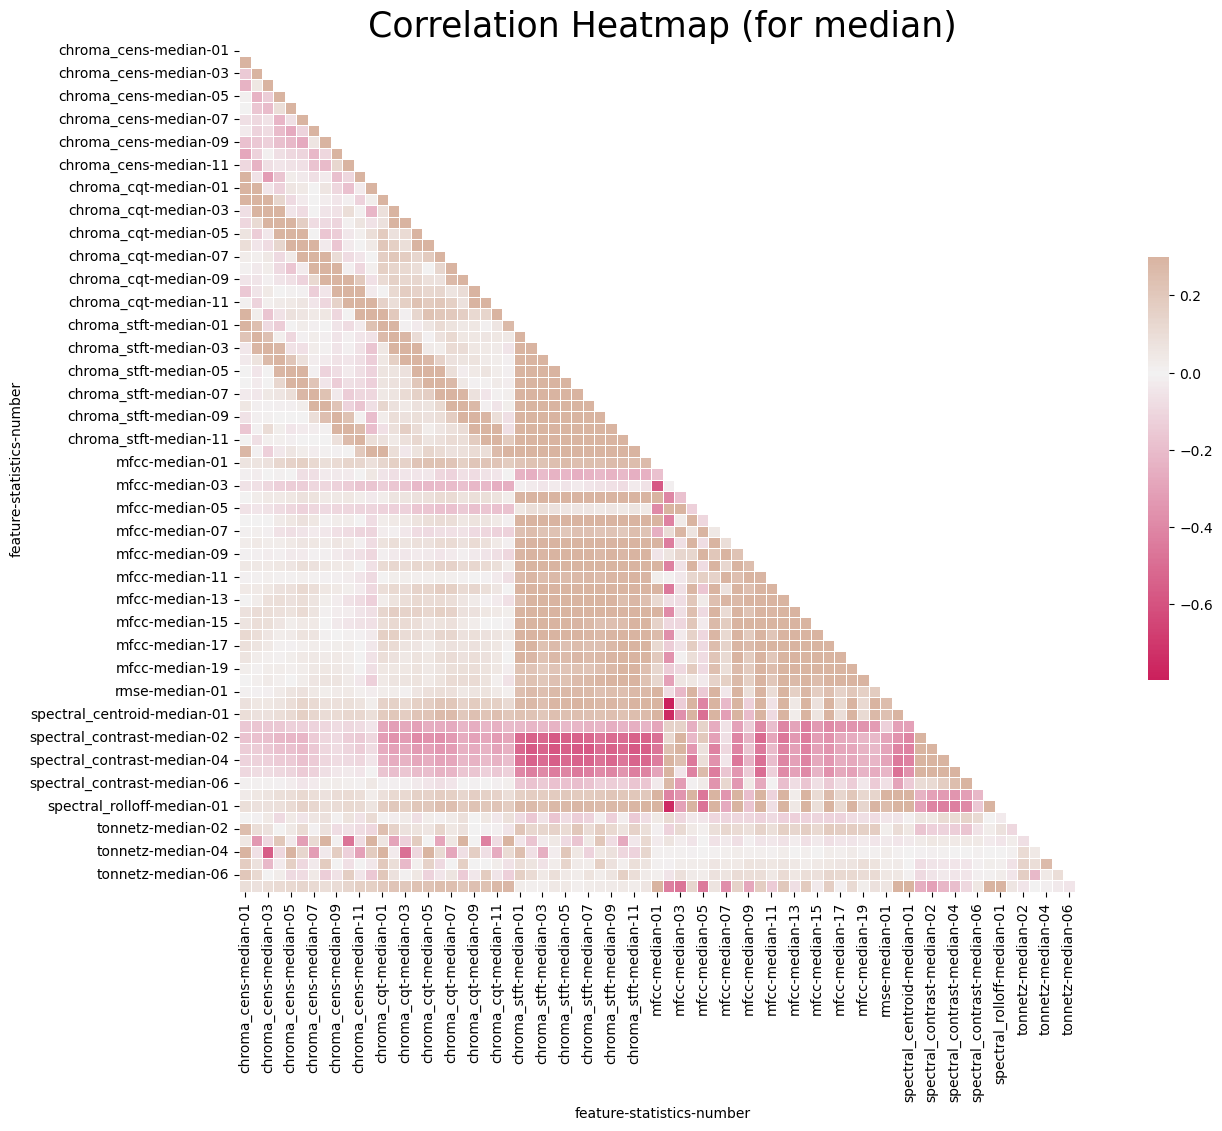

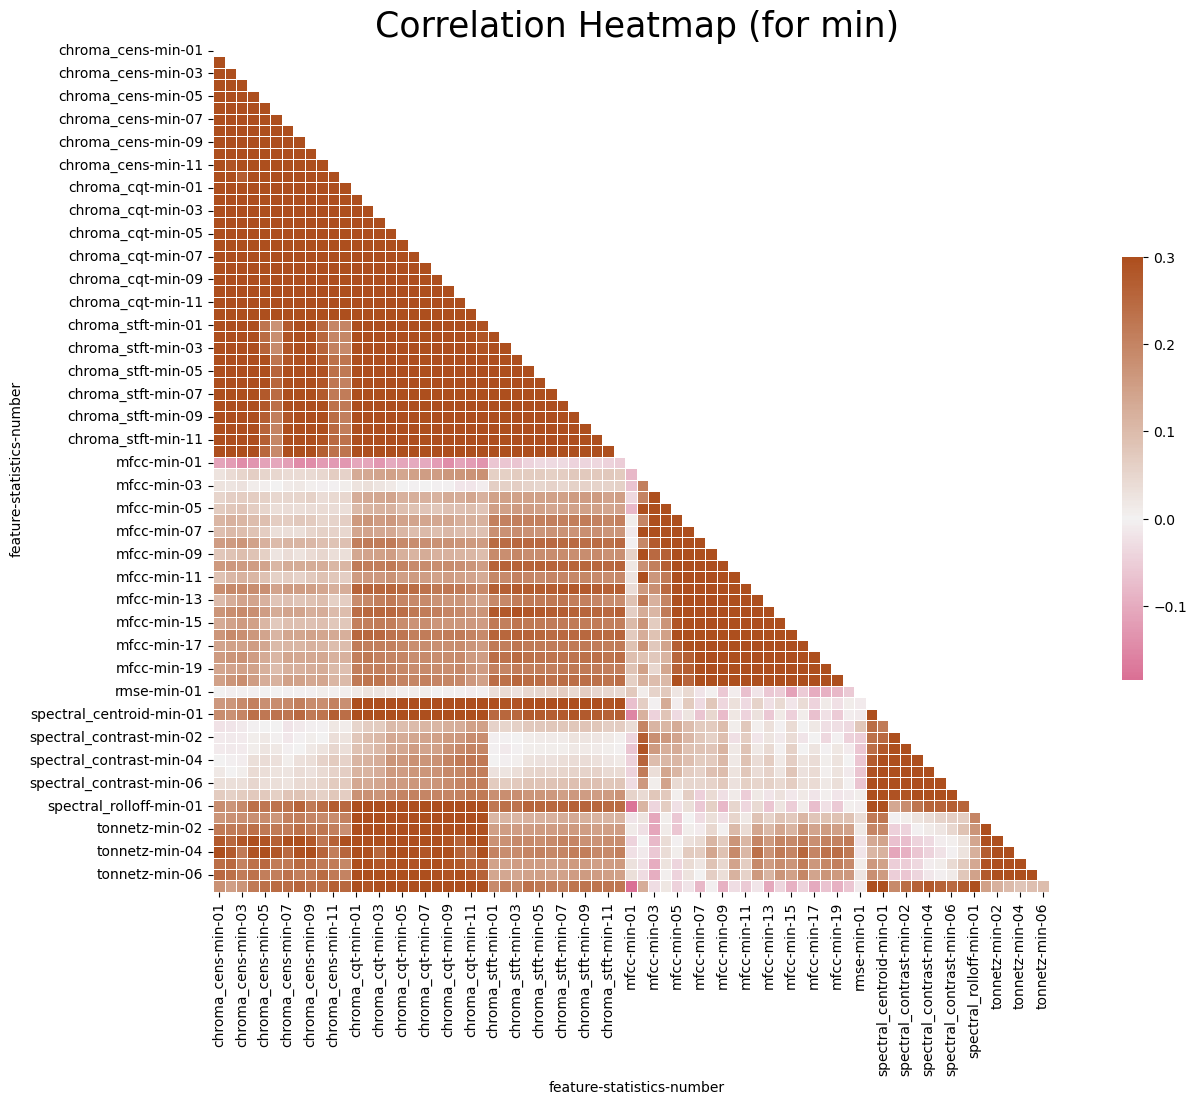

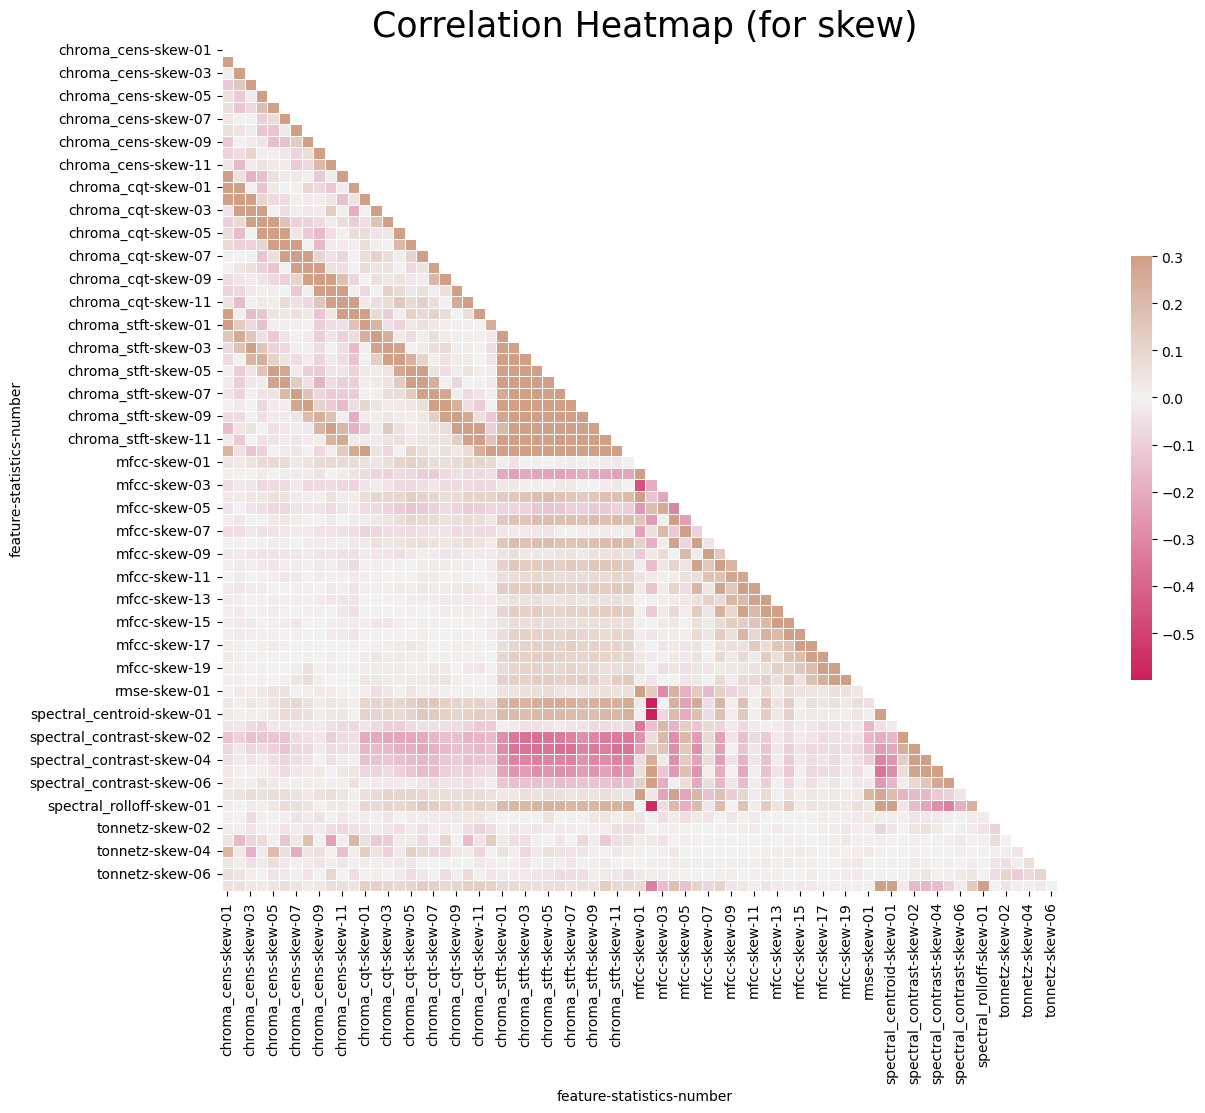

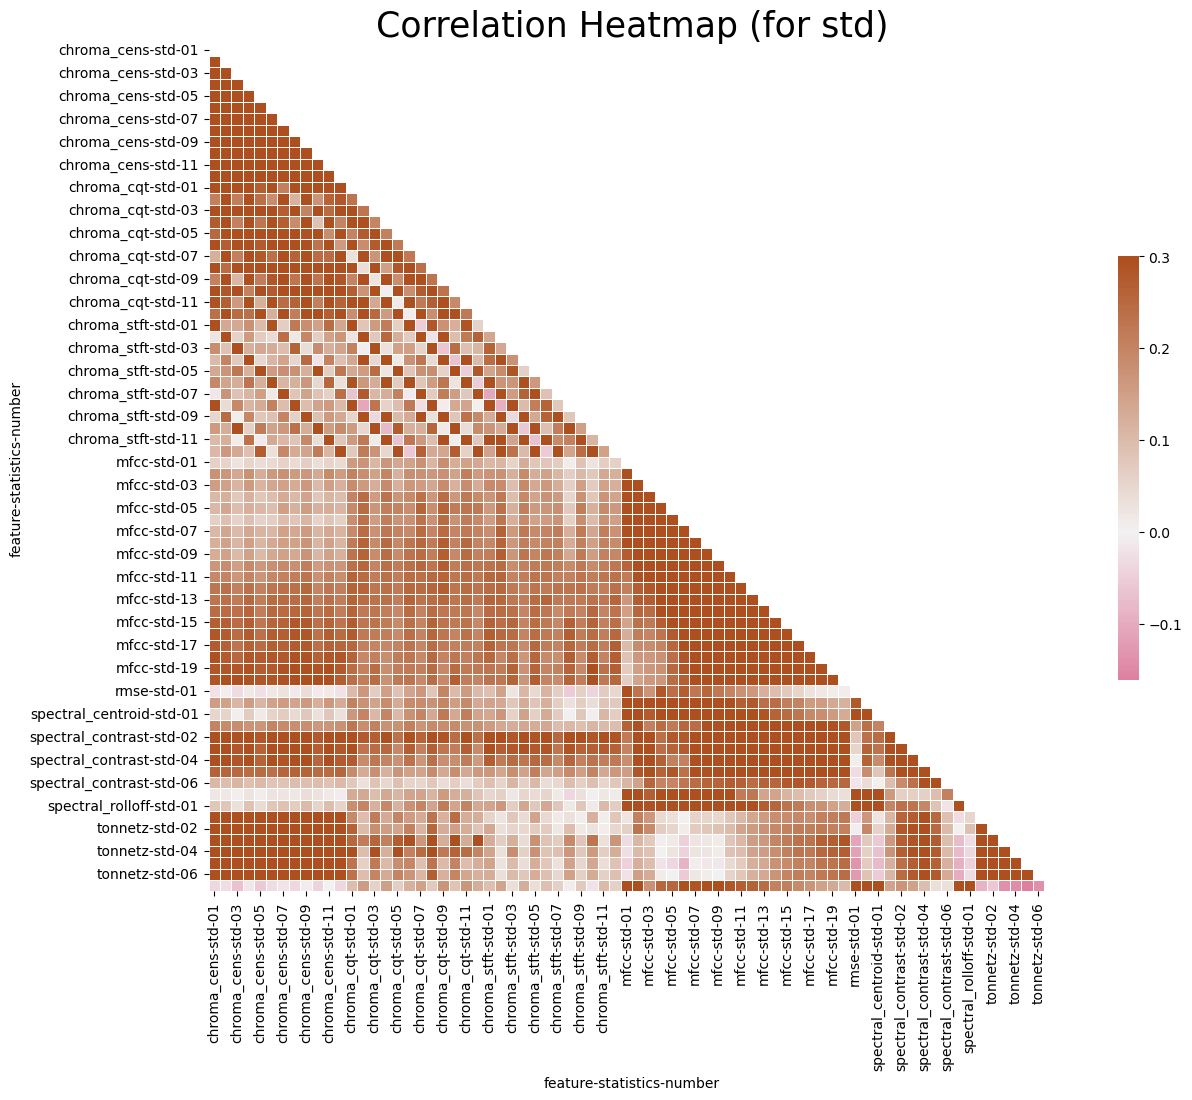

In [6]:
#  (may not be useful) plot correlations for each set of statistics

statistics = X.columns.get_level_values('statistics').unique()

for statistic in statistics:
    # obtain the columns for each feature
    cols = [col for col in X if col[1] == statistic]
    # find the correlation matrix
    corr = X[cols].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 11))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f'Correlation Heatmap (for {statistic})', fontsize = 25)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

## Pre-processing

In [7]:
from sklearn.model_selection import train_test_split
### split into train and test set ### 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024) # random seed will be set to 2024 throughout the codes for reproducibility

In [8]:
from sklearn import preprocessing

### normalisation ###
scaler = preprocessing.MinMaxScaler() # all mapped to [0, 1], uniform scaling
# the normaliser only uses information from the training set
X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X.columns) 
X_test_scaled = pd.DataFrame(data=scaler.transform(X_test), columns=X.columns)

## PCA for dimension reduction

In [9]:
### use PCA to reduce the dimension ###
from sklearn.decomposition import PCA

# perform the full PCA decomposition
pca = PCA(n_components=p)
# find the principal compoennts
X_train_PC = pd.DataFrame(data = pca.fit_transform(X_train_scaled), columns = [f'PC {i}' for i in range(1, p+1)])

# concatenate labels 
data_PCA = pd.concat([X_train_PC, y_train], axis=1)

explained_variances = pca.explained_variance_ratio_


Text(0, 0.5, 'ratio of explained variance')

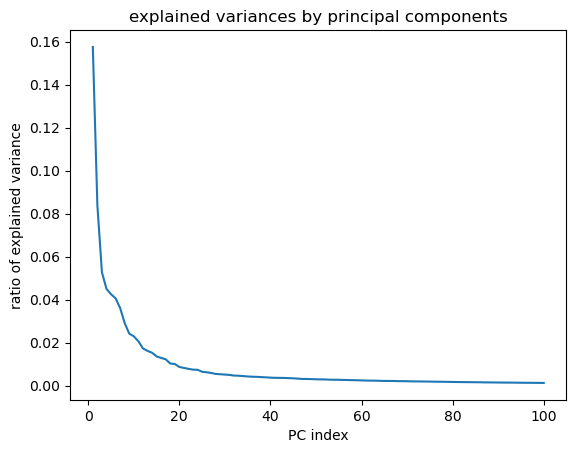

In [10]:
plt.plot(range(1, 101), explained_variances[:100])
plt.title('explained variances by principal components')
plt.xlabel('PC index')
plt.ylabel('ratio of explained variance')

In [11]:
### by elbow method, take roughly 20 principal components ###

n_PCA = 20

elbow method: take around 20 PCs as features

## Classical Training Models
Naive Bayes, two-layer perceptron, linear SVM, kernel SVM, random forests (and with gradient boosting) 

In [12]:
### Try Various Machien Learning Algorithms ###
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

In [13]:
### casual trainings with no tuning ###
nb =  GaussianNB() # Naive bayes: no randomness, no parameters
sgd = SGDClassifier(max_iter=4000, random_state=2024)
tree = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=2024)
svm = SVC(decision_function_shape="ovo", random_state=2024)
lg = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=2024)
nn = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(64, 8), random_state=2024) # single layer perceptron
xgb = XGBClassifier(n_estimators=500, learning_rate=0.04, random_state=2024)
xgbrf = XGBRFClassifier(objective= 'multi:softmax', random_state=2024)

algorithms_notuning = {
    'naive_Bayes': nb,
    'SGD' : sgd,
    'Decision_tree': tree,
    'random_forest': rf,
    'SVM': svm,
    'logistic_regression': lg,
    'neural network': nn,
    'cross-gradient boosting tree': xgb,
    'cross-gradient boosting': xgbrf
}

### PCA for dimension-reduction

In [14]:
## use PCA to reduce dimension. n = 20
pca_20 = PCA(n_components=n_PCA)
X_train_PC = pd.DataFrame(data = pca_20.fit_transform(X_train_scaled), columns = [f'PC {i}' for i in range(1, n_PCA+1)])

In [15]:
from sklearn.metrics import f1_score, accuracy_score

# transform test set using PCA fitted with training set
X_test_PCA = pd.DataFrame(data=pca_20.transform(X_test_scaled), columns = [f'PC {i}' for i in range(1, n_PCA+1)])

def model_PCA(model, name):
    """
    Train a model using PCA with 20 components as dimension-reduction techniquqe, 
    and assess the classification performance using accuracy and F1 score

    :param model: any object with functions `fit` and `predict` defined
    :param: name: String, the name of the algorithm, will be printed 
    """
    model.fit(X_train_PC, y_train)
    y_pred = model.predict(X_test_PCA)
    print('Test set Accuracy of', name, ':', round(accuracy_score(y_test, y_pred), 5), '\n')
    print('Test set F1 score of', name, ':', round(f1_score(y_test, y_pred, average='macro'), 5), '\n')

In [16]:
for name, algorithm in algorithms_notuning.items():
    model_PCA(algorithm, name)

Test set Accuracy of naive_Bayes : 0.41917 

Test set F1 score of naive_Bayes : 0.4058 

Test set Accuracy of SGD : 0.40583 

Test set F1 score of SGD : 0.38226 

Test set Accuracy of Decision_tree : 0.295 

Test set F1 score of Decision_tree : 0.29561 

Test set Accuracy of random_forest : 0.475 

Test set F1 score of random_forest : 0.4652 

Test set Accuracy of SVM : 0.51667 

Test set F1 score of SVM : 0.51094 

Test set Accuracy of logistic_regression : 0.45583 

Test set F1 score of logistic_regression : 0.44115 



/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test set Accuracy of neural network : 0.485 

Test set F1 score of neural network : 0.47953 

Test set Accuracy of cross-gradient boosting tree : 0.49167 

Test set F1 score of cross-gradient boosting tree : 0.49131 

Test set Accuracy of cross-gradient boosting : 0.445 

Test set F1 score of cross-gradient boosting : 0.43269 



### Fisher's LDA for dimension reduction

In [17]:
### Use LDA classifier ###
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

LDAclassifier = LinearDiscriminantAnalysis(n_components=7) # 7 classes in total 
LDAclassifier.fit(X_train_scaled, y_train)
y_pred = LDAclassifier.predict(X_test_scaled)
print('Test Accuracy of LDA classifiers', ':', round(accuracy_score(y_test, y_pred), 5), '\n')

Test Accuracy of LDA classifiers : 0.5525 



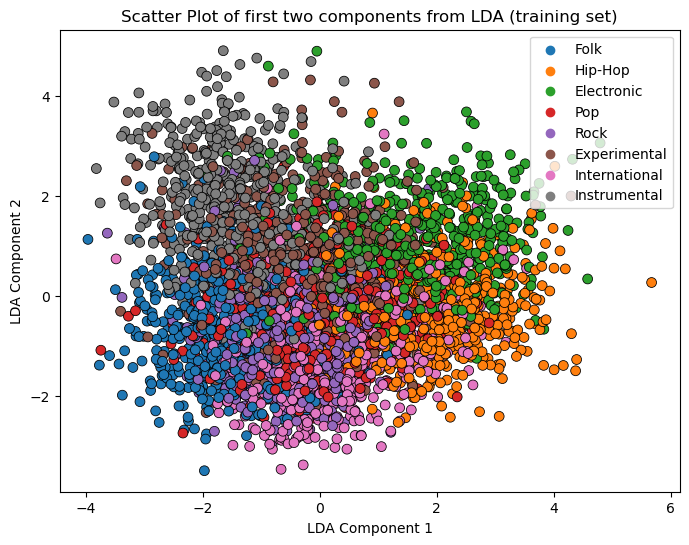

In [18]:
### Use LDA to reduce dimension, and apply other algorithms ###

X_train_LDA = LDAclassifier.transform(X_train_scaled)
X_test_LDA = LDAclassifier.transform(X_test_scaled)

df_train_LDA = pd.DataFrame(data=X_train_LDA, columns=[f'LDA_{i}' for i in range(1, 8)])

reverse_label_mapping = {v: k for k, v in label_mapping.items()}
y_train_str = [reverse_label_mapping[y] for y in y_train]


# Scatter plot of first two LDA components with colors representing class labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LDA_1', y='LDA_2', hue=y_train_str, data=df_train_LDA, edgecolor='black', s=50)
plt.title('Scatter Plot of first two components from LDA (training set)')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

In [19]:
label_mapping

{'Folk': 0,
 'Hip-Hop': 1,
 'Rock': 2,
 'International': 3,
 'Electronic': 4,
 'Instrumental': 5,
 'Pop': 6,
 'Experimental': 7}

In [20]:
np.unique(y_train.astype(int))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [21]:
def model_LDA(model, name):
    """
    Train a model using LDA as dimension-reduction techniquqe, 
    and assess the classification performance using accuracy and F1 score

    :param model: any object with functions `fit` and `predict` defined
    :param name: String, the name of the algorithm, will be printed 
    """

    model.fit(X_train_LDA, y_train)
    y_pred = model.predict(X_test_LDA)
    print('Test Accuracy of', name, ':', round(accuracy_score(y_test, y_pred), 5), '\n')
    print('Test set F1 score of', name, ':', round(f1_score(y_test, y_pred, average='macro'), 5), '\n')

In [22]:
for name, algorithm in algorithms_notuning.items():
    model_LDA(algorithm, name)

Test Accuracy of naive_Bayes : 0.55583 

Test set F1 score of naive_Bayes : 0.55804 

Test Accuracy of SGD : 0.53917 

Test set F1 score of SGD : 0.53619 

Test Accuracy of Decision_tree : 0.44167 

Test set F1 score of Decision_tree : 0.43992 

Test Accuracy of random_forest : 0.55 

Test set F1 score of random_forest : 0.54636 

Test Accuracy of SVM : 0.54833 

Test set F1 score of SVM : 0.54759 

Test Accuracy of logistic_regression : 0.55333 

Test set F1 score of logistic_regression : 0.55338 



/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Test Accuracy of neural network : 0.54333 

Test set F1 score of neural network : 0.54263 

Test Accuracy of cross-gradient boosting tree : 0.53833 

Test set F1 score of cross-gradient boosting tree : 0.53713 

Test Accuracy of cross-gradient boosting : 0.56333 

Test set F1 score of cross-gradient boosting : 0.56048 



Conclusion: LDA is better than PCA for dimension reduction. Deicion trees will be discarded because the ensemble tree method always work better

## Cross-validation training

In [23]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [24]:
# use LDA to reduce dimensions
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_LDA = LDA.transform(X_train_scaled)

In [25]:
# SGD tuning: regularisation strength, penalty and loss 
sgd = SGDClassifier(max_iter=5000)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': list(sgd.loss_functions)
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)

    grid_SGD = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy')
    grid_SGD.fit(X_train_LDA, y_train)

/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:165: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `los

In [26]:
print(grid_SGD.best_params_)
grid_SGD.best_score_

{'alpha': 0.01, 'loss': 'log', 'penalty': 'elasticnet'}


0.703125

In [27]:
# Random Forest tuning:  
param_grid = {
    'n_estimators': [50, 100], # number of trees
    'max_depth': [None, 5, 10],
    'min_samples_split': [8, 10, 20], # minimum size of node for splitting
    'min_samples_leaf': [2, 4, 6],  # minimum leaf size 
    'max_features': ['auto', 'sqrt', 'log2', None] # number of features used in each tree
}

rf_classifier = RandomForestClassifier()

# Perform grid search with cross-validation
grid_RF = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy',n_jobs=-1)
# without dimension-reduction
grid_RF.fit(X_train, y_train)

/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'

KeyboardInterrupt: 

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=7)
rf_classifier.fit(X_train_scaled, y_train)
y_pred = rf_classifier.predict(X_test_scaled)

In [ ]:
print(accuracy_score(y_pred, y_test))

0.5091666666666667


In [ ]:
print(grid_RF.best_params_)
grid_RF.best_score_

In [ ]:
# tunig gradient boosting random forest
from xgboost import XGBRFClassifier

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2], # step size shrinkage used in each boosting iteration
    'n_estimators': [50, 100], # number of trees
    'max_depth': [5, 7, 10], # max tree depth
    'subsample': [0.6, 0.8], # fraction of samples used for fitting each tree
    'colsample_bynode': [0.6, 0.8], # fraction of features used for fitting each tree
    'gamma': [0, 0.1, 0.2], # Minimum loss reduction required to make a further partition on a leaf node of the tree.
}

# Create the XGBRFClassifier
xgbrf_classifier = XGBRFClassifier(random_state=42)

# Perform grid search with cross-validation
grid_xgb = GridSearchCV(xgbrf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print(grid_xgb.best_params_)
grid_xgb.best_score_

In [ ]:
## tuning Adaboost
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier()

# Define the parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 200], # number of trees
    'learning_rate': [0.01, 0.1, 0.5],
    'base_estimator__max_depth': [2, 4, 6] 
}

# Create the AdaBoostClassifier
adaboost = AdaBoostClassifier(base_estimator=base_estimator)

# grid search
grid_ada = GridSearchCV(adaboost, param_grid, cv=5, scoring='accuracy')
grid_ada.fit(X_train, y_train)

In [ ]:
print(grid_ada.best_params_)
grid_ada.best_score_

## MLP training using tensorflow

In [32]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer, PReLU, LeakyReLU
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
### dimension reduction -- LDA ### 
# use LDA
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_reduced = LDA.transform(X_train_scaled)
X_test_reduced = LDA.transform(X_test_scaled)

In [33]:
### dimension reduction -- ICA ###
from sklearn.decomposition import FastICA

ICA = FastICA(n_components=40, random_state=2024)
X_train_reduced = ICA.fit_transform(X_train_scaled)
X_test_reduced = ICA.transform(X_test_scaled)

/Users/linyuhang/mambaforge/envs/tf/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


2024-03-12 09:47:29.982429: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


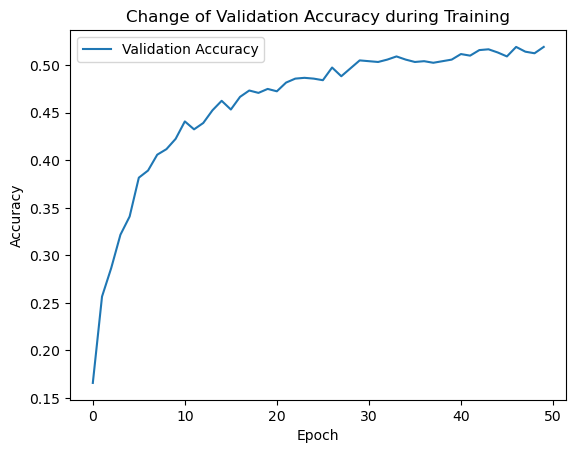

In [34]:
tf.random.set_seed(2024)
### set basic parameters
batch_size = 8
activation = 'prelu' # activation for the hidden layers: `relu`, `prelu`, `leakyrelu`
learning_rate = 1e-4
n_epoches = 50
dropout_rate = 0.5 # set to 0 to avoid drop-out
layer_widths = [128, 64] # number of hidden units in each hidden layer
n_layers = len(layer_widths)
normalisation = True

### define architecture:
base_architecture = Sequential()
base_architecture.add(InputLayer(input_shape=(X_train_reduced.shape[1],)))

# feedforward neural network 
for l in range(n_layers):
    if activation == 'relu':
        base_architecture.add(Dense(layer_widths[l], activation='relu'))
    else:
        base_architecture.add(Dense(layer_widths[l]))
    # dropout 
    base_architecture.add(Dropout(dropout_rate))
    # other activations
    if activation == 'prelu':
        base_architecture.add(PReLU())
    elif activation == 'leakyrelu':
        base_architecture.add(LeakyReLU())
    # normalisation
    if normalisation:
        base_architecture.add(BatchNormalization())

# add output layer
base_architecture.add(Dense(units=8, activation = 'softmax')) 

# define the model with Adam optimiser
model = Sequential.from_config(base_architecture.get_config())
model.compile(optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
history = model.fit(X_train_reduced, y_train, epochs=n_epoches, batch_size=batch_size, validation_data=(X_test_reduced, y_test), verbose=0)

def plot_val_accuracy(history):
    """ Plot the change of validation accuracy """
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Change of Validation Accuracy during Training')
    plt.legend()
    plt.show()

plot_val_accuracy(history)


In [ ]:
MLP_test_acc = history.history['val_accuracy'][-1]
print(f'test accuracy: {MLP_test_acc}')

test accuracy: 0.5508333444595337


## Superlearner
Ensemble method of the classical classifiers described above

In [15]:
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from xgboost import XGBRFClassifier

In [16]:
# create a list of base-models
classifiers = {}
## need to adjust the paramters !!!!!!! LDA procedure changed
classifiers['SGD_LM'] = SGDClassifier(max_iter=5000, alpha=0.001, loss='log_loss', penalty='l2')
classifiers['logistic'] = LogisticRegression(C=1, penalty='l1', solver='liblinear')
classifiers['Gradient_Boost'] = XGBRFClassifier(colsample_bynode=0.6, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6)

In [17]:
# collect out of fold predictions form k-fold cross validation
def out_of_fold_predictions(X, y, models):
	"""
	param X: input data
	param y: class labels
	models: based models for the super-learner
	"""
	X_out, y_out = list(), list()
	# define partition of data into 10 folds
	kfold = KFold(n_splits=10, shuffle=True)
	# enumerate splits
	for train_ids, test_ids in kfold.split(X):
		y_preds = list()
		# split data
		X = np.array(X)
		X_train, X_test = X[train_ids], X[test_ids]
		y = np.array(y)
		y_train, y_test = y[train_ids], y[test_ids]
		y_out.extend(y_test)
		# fit and make predictions with each base model
		for _, model in models.items():
			model.fit(X_train, y_train)
			y_probs = model.predict_proba(X_test)
			# store columns
			y_preds.append(y_probs)
		# store fold yhats as columns
		X_out.append(np.hstack(y_preds))
	return np.vstack(X_out), np.asarray(y_out)

In [18]:
def fit_base(X, y, models):
	for name, model in models.items():
		if name != 'MLP':
			model.fit(X, y)

## used on out-of-fold predictions
def fit_meta(X, y):
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return model

def superlearner_predict(X, models, meta_model):
	meta_X = list()
	for _, model in models.items():
		y_probs = model.predict_proba(X)
		meta_X.append(y_probs)
	meta_X = np.hstack(meta_X)
	return meta_model.predict(meta_X)

In [23]:
# use LDA to reduce dimensions
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train_scaled, y_train)
X_train_LDA = LDA.transform(X_train_scaled)
X_test_LDA = LDA.transform(X_test_scaled)

meta_X, meta_y = out_of_fold_predictions(X_train_LDA, y_train, classifiers)

fit_base(X_train_LDA, y_train, classifiers)
meta_model = fit_meta(meta_X, meta_y)

y_pred = superlearner_predict(X_test_LDA, classifiers, meta_model)
print('Super Learner test accuracy: %.3f' % (accuracy_score(y_test, y_pred) * 100))

Super Learner test accuracy: 55.333


In [ ]:
##### using mlens superlearner package #####
from mlens.ensemble import SuperLearner

sp = SuperLearner()
sp.add(LogisticRegression())
sp.add(LinearDiscriminantAnalysis())
sp.add(XGBRFClassifier())
sp.add_meta(LogisticRegression())

sp.fit(X_train_reduced, y_train)
y_pred = sp.predict(X_test_reduced)
print('Super Learner test accuracy: %.3f' % (accuracy_score(y_test, y_pred) * 100))

## CNN approach

In [38]:
### import required libraries ###
import keras, os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# set parameters
lr = 1e-3
patience = 5 # early stopping patience
n_epoches = 100 # number of epoches for training

### VGG-16 architecture 
VGG16 = Sequential(
    # block 1 (input block)
    # only uses the three chromagrams 
    Conv2D(input_shape=(7, 12, 3), filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), 
    # block 2
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), 
    # block 3
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), 
    # block 4
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), 
    # block 5
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)), 
    # FeedForward Neural network
    Flatten(),
    Dense(units=512, activation='ReLU'),
    Dropout(0.3),
    Dense(units=512, activation='ReLU'),
    Dense(units=8, activation='ReLU'), # classification layer
)

VGG16.compile(optimizer=Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

## early stopping
early = EarlyStopping(monitor='val_acc', patience=patience, verbose=1, mode='auto', restore_best_weights=True)
# transform the dataset
X_train_chroma = X_train_scaled[['chroma_cens', 'chroma_cqt', 'chroma_stft']].to_numpy().reshape(-1, 7, 12, 3)
X_test_chroma = X_test_scaled[['chroma_cens', 'chroma_cqt', 'chroma_stft']].to_numpy().reshape(-1, 7, 12, 3)

history = VGG16.fit(X_train_chroma, y_train, epochs=n_epoches, validation_data=(X_test_chroma, y_test),  callbacks=[early])

In [ ]:
## plot result

import matplotlib.pyplot as plt
plt.plot(history.history["acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Export final prediction in csv format 

In [ ]:
X_output = pd.read_csv('data/X_test.csv', index_col = 0, header=[0, 1, 2]) # inputs of the test set
y_output = ...

In [ ]:
# Export the predictions on the test data in csv format
prediction = pd.DataFrame(y_output, columns=['Genre'])
prediction.index.name='Id'
prediction.to_csv('data/myprediction.csv') # export to csv file